In [19]:
import pandas as pd

class FeatureRecorder():
    def __init__(self, recorder_config) -> None:
        self.logs = []
        self.records = {}
        self.length = 0
        self.config = recorder_config
        for config_item in recorder_config:
            self.records[config_item] = []

    def begin_recording(self,  remain_content=True, remain_record_objective=True):
        if not remain_record_objective:
            self.clear_all()
        elif not remain_content:
            self.clear_all_content()
        self.logs.append([self.length, -1])
        
    
    def end_recording(self):
        self.logs[-1][1] = self.length - 1
            
    def record_at_t(self, window, time = -1):
        record_name = 0
        for record_name in self.records:
            item = self.config[record_name]
            if not item['enabled']:
                val = None
            else:
                func = item['func']
                val = func(window)
            if time < 0 or time >= self.length:
                self.records[record_name].append(val)
            else:
                self.records[record_name][time] = val
        self.length += 1
            
    def append_record(self, window = -1):
        self.record_at_t(window, -1)
        
    def clear_all_content(self):
        return
    
    def clear_all():
        return
    def get_dataframe(self):
        return pd.DataFrame(self.records)
    
class RecordConfiguration():
    def __init__(self) -> None:
        self.record_objectives = {
        }
    def add_record_object(self, name, func):
        self.record_objectives[name] = {'enabled': True, 'func': func}

    def enable_record_item(self, name):
        if name not in self.record_objectives:
            return
        self.record_objectives[name]['enabled'] = True
        
    def __iter__(self):
        return self.record_objectives.__iter__()
    
    def __getitem__(self, key):
        return self.record_objectives[key]
        
class FeatureExtractor():
    def __init__(self, freq, decision_time_delay):
        self.freq = freq
        self.decision_time_delay = decision_time_delay
        
    
    def do_extraction(self, signal, feature_recorder, append_record_mode = True, time_limit = -1):
        current_time = 0
        def window_views(signal, time_delay):
            T = signal.shape[0]
            for t in range(0, T):
                yield signal[max(0, t - time_delay): t + 1, :]
        
        if append_record_mode:
            feature_recorder.begin_recording(True, True)
        else:
            feature_recorder.begin_recording(False, True)

            
            
        for window in window_views(signal, int(self.freq * self.decision_time_delay)):
            if append_record_mode:
                feature_recorder.append_record(window)
            else:
                feature_recorder.record_at_t(window, current_time)
            current_time += 1
            if time_limit >= 0 and current_time >= time_limit:
                break
            
        feature_recorder.end_recording()
        return feature_recorder

In [20]:
import numpy as np
import os, sys

In [21]:
sys.path.append("../data/dataset")
sys.path.append("..//microstate_lib/code")
from dataset import *

In [22]:
dataset_facade = EEGDatasetFacade(dataset_base_path="../data")

In [23]:
dataset = dataset_facade("ethz-ieeg")

In [24]:
data = dataset.get_mne_data(['long', 1, 118])

Creating RawArray with float64 data, n_channels=88, n_times=1843200
    Range : 0 ... 1843199 =      0.000 ...  3599.998 secs
Ready.


In [25]:
freq = data.info['sfreq']
feature_extractor = FeatureExtractor(freq, int(10))

In [29]:
import scipy
config = RecordConfiguration()
n_channels = 88


from recorder_builder import *
recorder = build_recorder_config(19)

ImportError: attempted relative import with no known parent package

In [27]:
recorder = feature_extractor.do_extraction(data.get_data().T, recorder, time_limit=100)

C:\Users\Micro\AppData\Local\Temp\ipykernel_7228\348146697.py:18: RuntimeWarning: divide by zero encountered in log
  return np.sum([p_ij * np.log(p_ij) for p_ij in mut_inf / np.sum(mut_inf)])
C:\Users\Micro\AppData\Local\Temp\ipykernel_7228\348146697.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sum([p_ij * np.log(p_ij) for p_ij in mut_inf / np.sum(mut_inf)])
C:\Users\Micro\AppData\Local\Temp\ipykernel_7228\348146697.py:24: RuntimeWarning: invalid value encountered in divide
  return flatten_remove_diag(mutual_information_2d) / s


In [23]:
def build_visuality_graph(one_dimensional_signal):
    width = len(one_dimensional_signal)
    value_diff = np.repeat(one_dimensional_signal[:,np.newaxis].T, width, axis=0) - np.repeat(one_dimensional_signal[:,np.newaxis], width, axis=1)
    time_differ = np.repeat(np.arange(0, width)[:,np.newaxis].T, width, axis=0) - np.repeat(np.arange(0, width)[:,np.newaxis], width, axis=1)
    graph = np.arctan(value_diff / value_diff)
    return graph

In [24]:
delta_y = (np.repeat(np.array([2, 4, 9, 3, 2])[:,np.newaxis].T, 5, axis=0) - np.repeat(np.array([2, 4, 9, 3, 2])[:,np.newaxis], 5, axis=1))
delta_t = (np.repeat(np.array([1, 2, 3, 4, 5])[:,np.newaxis].T, 5, axis=0) - np.repeat(np.array([1, 2, 3, 4, 5])[:,np.newaxis], 5, axis=1))
np.arctan(delta_y / delta_t)

C:\Users\Micro\AppData\Local\Temp\ipykernel_23192\3703664283.py:3: RuntimeWarning: invalid value encountered in divide
  np.arctan(delta_y / delta_t)


array([[        nan,  1.10714872,  1.29249667,  0.32175055,  0.        ],
       [ 1.10714872,         nan,  1.37340077, -0.46364761, -0.5880026 ],
       [ 1.29249667,  1.37340077,         nan, -1.40564765, -1.29249667],
       [ 0.32175055, -0.46364761, -1.40564765,         nan, -0.78539816],
       [-0.        , -0.5880026 , -1.29249667, -0.78539816,         nan]])

In [13]:
# Compare follow things
# - Information Theory Appraoch (How dynamics of a feature give us information about system s2.)
#   - Mutual information
#   - Transfer Entropy
#   - Canonical Correlation Analysis (CCA)
#   - Granger Causality
#   - Correlation Analysis


# Geometry Approach



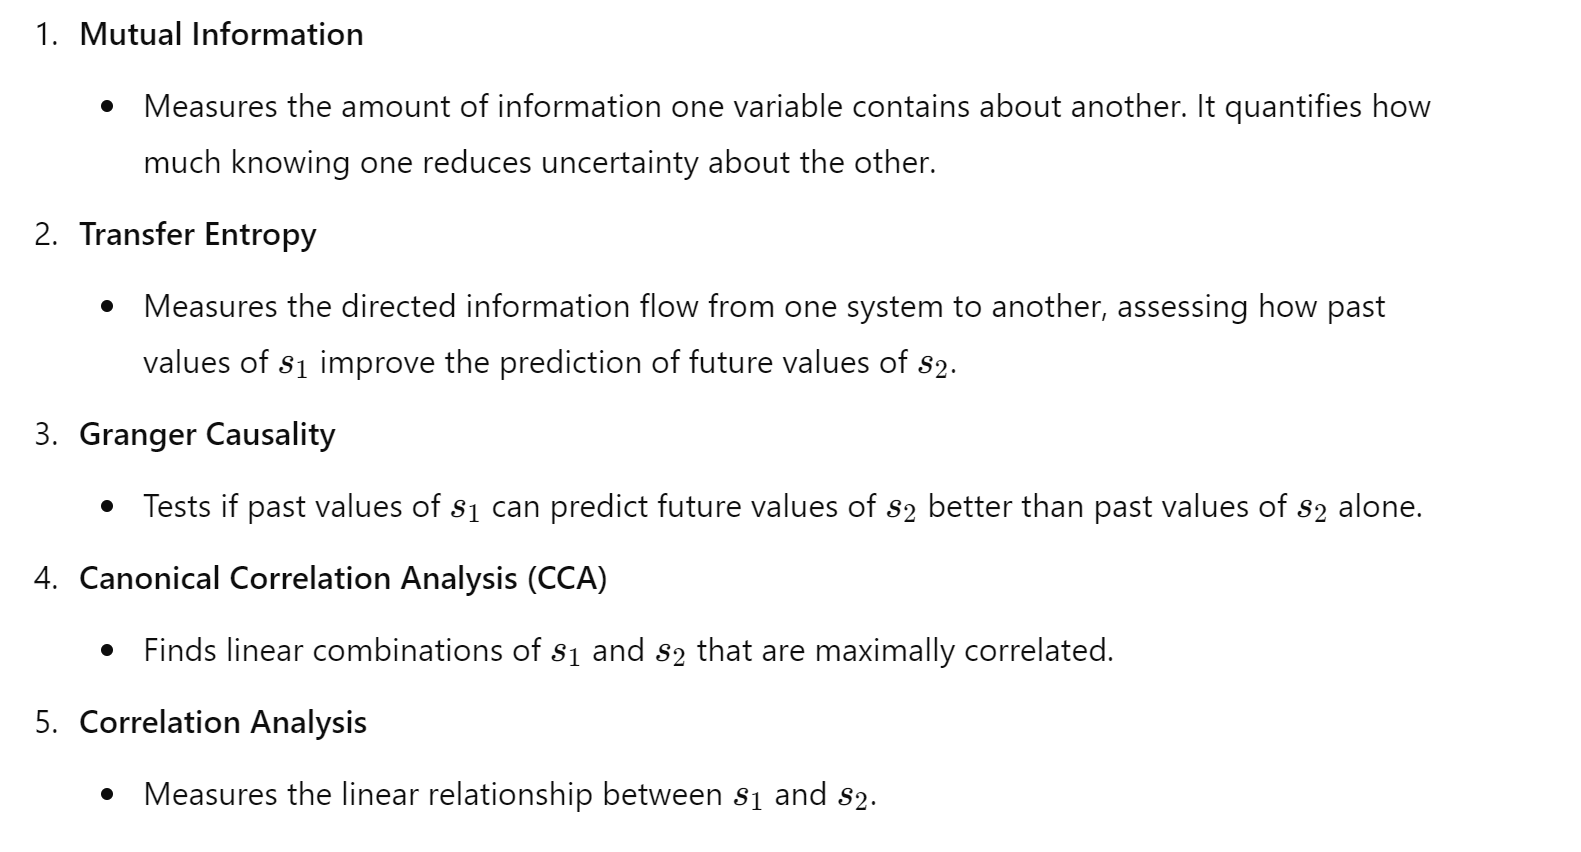

def build_reservior():